Already have ample experience with KDEs so I will go quickly through this

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import pandas as pd
from scipy import stats

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%config IPCompleter.use_jedi = False

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
from sklearn.neighbors import KernelDensity



In [3]:
from sklearn.datasets import fetch_species_distributions

data = fetch_species_distributions()

# Get matrices/arrays of species IDs and locations
latlon = np.vstack([data.train['dd lat'],
                    data.train['dd long']]).T
species = np.array([d.decode('ascii').startswith('micro')
                    for d in data.train['species']], dtype='int')

In [10]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt


In [17]:
from sklearn.datasets import species_distributions



In [18]:
xgrid, ygrid = species_distributions.construct_grids(data)



In [20]:
xgrid, ygrid

(array([-94.75, -94.7 , -94.65, ..., -34.3 , -34.25, -34.2 ]),
 array([-56.  , -55.95, -55.9 , ...,  23.45,  23.5 ,  23.55]))

In [36]:
extent = [xgrid.min(), xgrid.max(), ygrid.min(), ygrid.max()]

In [53]:
def add_features(ax):
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN, alpha=0.5)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    return None

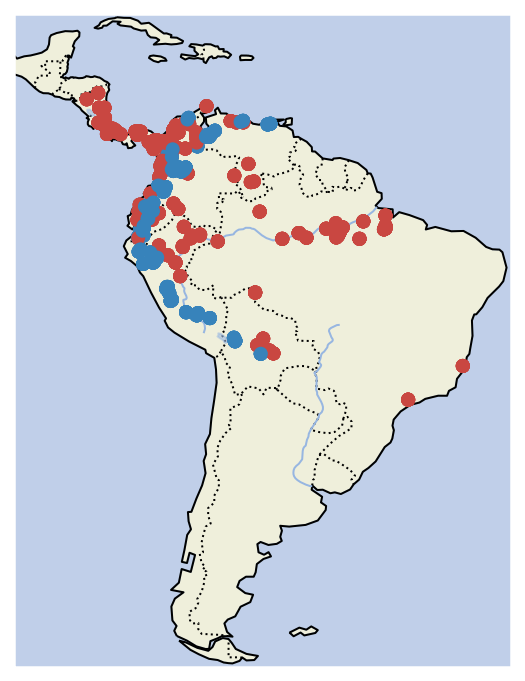

In [54]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent(extent, crs=ccrs.PlateCarree())

add_features(ax)

plt.scatter(latlon[:, 1], latlon[:, 0], zorder=3,
          c=species, cmap='RdBu', vmin=-.25,vmax=1.25)

plt.show()

### KDE on geographical data


> we will use the haversine distance metric which will correctly represent distances on a curved surface. 

In [89]:
# Set up the data grid for the contour plot
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > -9999).ravel()
xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = np.radians(xy[land_mask])

In [112]:
def make_kde_plot(ax):
    
    kde = KernelDensity(bandwidth=0.03, metric='haversine')
    kde.fit(np.radians(latlon[species == i]))

    # evaluate only on the land: -9999 indicates ocean
    Z = np.full(land_mask.shape[0], -9999.0)
    Z[land_mask] = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)
#     print(Z[Z>-9999])
    # plot contours of the density
    levels = np.linspace(0.1, Z.max(), 25)
    ax.contourf(X, Y, Z, levels=levels, cmap=cmaps[i])

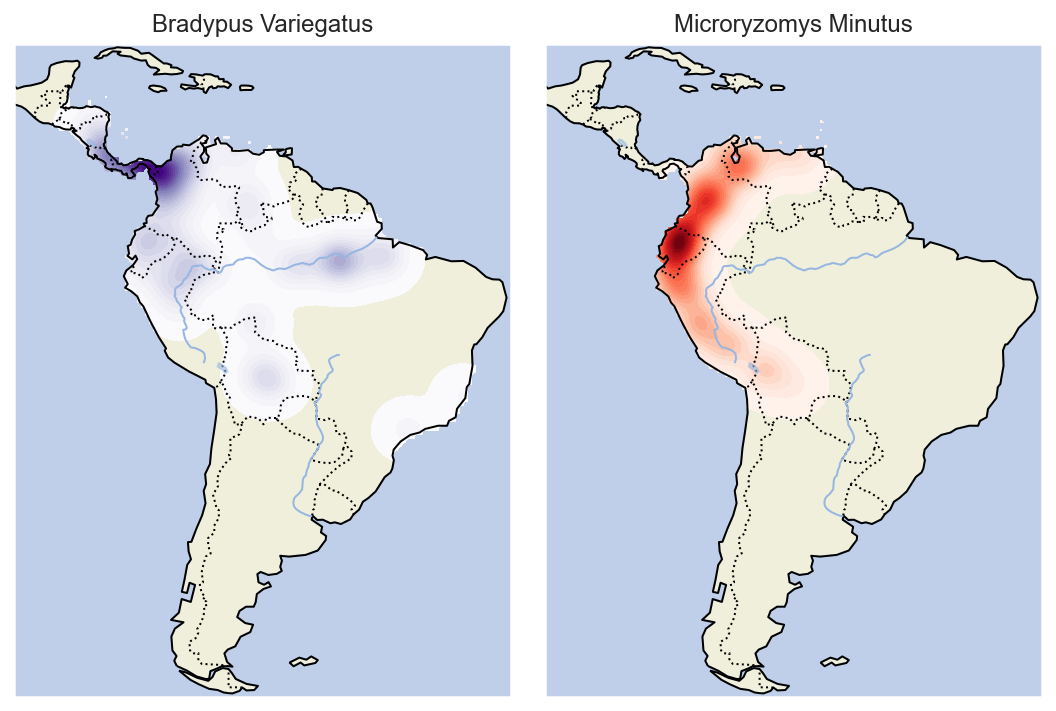

In [114]:
# Create two side-by-side plots
fig, axes = plt.subplots(ncols=2, figsize=(8,6), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)
species_names = ['Bradypus Variegatus', 'Microryzomys Minutus']
cmaps = ['Purples', 'Reds']

for i, ax in enumerate(axes.flat):
    ax.set_title(species_names[i])
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    add_features(ax)
    make_kde_plot(ax)